# Analyzing the Effect of High Dimensional Noise on Different Clustering Algorithms

In this experiment the effect of addition of high dimensional noise in the performance of different clustering algorithms is analyzed. The algorithms under consideration are agglomerative clustering, k-means clustering, DBSCAN, and GMM. To start with, synthetic datasets are generated using make_blobs, make_classification,make_moons, and make_circles, to each of which gaussian noises with different variances and dimensions are added. On this new set of datatsets the clustering algorithms are performed and adjusted rand index is used as a metric to measure the performance of the algorithms under these different scenarios. 

In [234]:
import time
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from sklearn.metrics import adjusted_rand_score

from tqdm import tqdm

plt.rcParams.update({'font.size': 15})

## Generating synthetic datasets and defining the parameters for the clustering algorithms

The original datasets are 2-dimensional with 500 samples and 2 cluster classes. Later, n noise dimensions are added to the original datasets where n=0,10,...,100. 

In [235]:
'''defining datasets'''
noiseDimensions=np.arange(0,110,10)
noise_levels=[0.1,1,10]
noiseRange=len(noiseDimensions)
trialNum=100
parameters={'samples':500,'features':2,'clusters':2,'eps': .3,'damping':0.9,'preference':-200}

blobs = datasets.make_blobs(n_samples=samples, # make sure variance along both the dimensions are 1
                            centers=clusters,
                            cluster_std=1,
                            random_state=0)
moons = datasets.make_moons(n_samples=samples, 
                            noise=1)
circles = datasets.make_circles(n_samples=samples, 
                                factor=0.8,
                                noise=1)
classification = datasets.make_classification(n_samples=samples, 
                                  n_features=features,
                                  n_informative=features,
                                  n_redundant=0,
                                  n_repeated=0,
                                  n_classes=clusters,
                                  n_clusters_per_class=1,
                                  flip_y=0.1,
                                  random_state=None,
                                  shuffle=True)

datasets = [blobs,classification,circles,moons]
names=['make_blobs','make_classification','make_circles','make_moons']

clustering_algorithms = [cluster.KMeans(n_clusters=parameters['clusters']),
                         cluster.AgglomerativeClustering(n_clusters=parameters['clusters'],linkage='ward'),
                         cluster.DBSCAN(eps=parameters['eps']),
                         mixture.GaussianMixture(n_components=parameters['clusters'],covariance_type='full'),
                         cluster.SpectralClustering(n_clusters=parameters['clusters'],eigen_solver='arpack',affinity='nearest_neighbors'),
                         cluster.AffinityPropagation(damping=parameters['damping'],preference=parameters['preference'])]
clustering_names=['K-means Clustering','Agglomerative Clustering','DBSCAN','GMM','Spectral Clustering','Affinity Propagation']

The plots below show how the data points are originally clustered.

Text(530.2875, 0.5, 'X2')

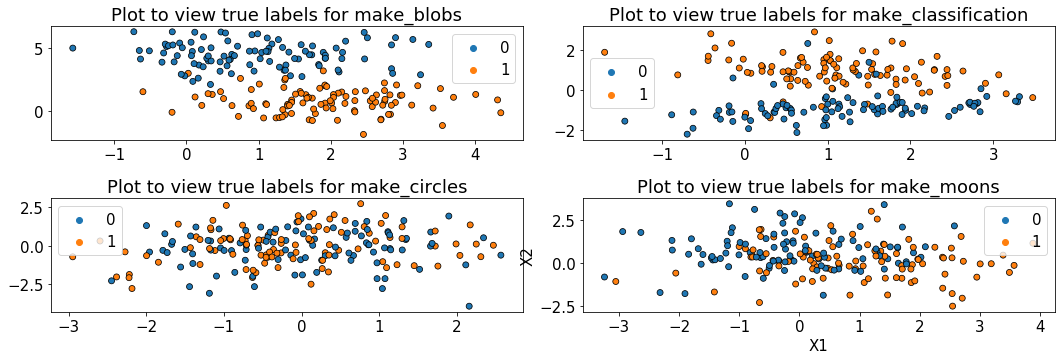

In [236]:
'''Plotting the data'''
f, axes = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    plt.subplot(2,2,index+1)
    sns.scatterplot(dataset[0][:,0],dataset[0][:,1],hue=dataset[1],edgecolor='black')
    plt.title('Plot to view true labels for ' + name)
    plt.tight_layout()
plt.xlabel('X1')
plt.ylabel('X2')

## Adding high dimensional noise
The following function adds noise of any given dimension and standard deviation to the data.

In [237]:
'''Adding high dimensional noise'''
def addNoise(x,noiseDim,noise_std,samples=samples,noise_mean=0):
    tempNoise=np.random.normal(noise_mean,noise_std,[samples,noiseDim])
    data=np.concatenate((x,tempNoise),axis=1)
    return data

## Computing the accuracy

This is the crucial step in the experiment. To every dataset, noises of different dimensions are added, on which different clustering methods are performed. This is repeated 25 times and the plots that incorporate the mean and variance for each iteration are plotted. 

In [238]:
def accuracy(algorithm,dataX,dataY):
    cluster=algorithm.fit(dataX)
    label=cluster.labels_
    ARI=adjusted_rand_score(label,dataY)
    return ARI

def accuracyGaussian(algorithm,dataX,dataY):
    cluster=algorithm.fit(dataX)
    label=cluster.predict(dataX)
    ARI=adjusted_rand_score(label,dataY)
    return ARI

def toPlot(noiseStd):
    ARI=np.zeros((len(datasets),len(clustering_algorithms),trialNum,noiseRange))
    allTrialARI=np.zeros((len(datasets),len(clustering_algorithms),noiseRange*trialNum)) # to create dataframe
    theNoiseDim=np.zeros((len(datasets),len(clustering_algorithms),noiseRange*trialNum))
    allARI=[[],[],[],[]]
    event=[[],[],[],[]]
    allNoise=[[],[],[],[]]
    for index,dataset in enumerate(datasets):
        for ind,algorithm in enumerate(clustering_algorithms):
            for trial in range(trialNum):
                for noiseIndex,noise in enumerate(noiseDimensions):
                    newX=addNoise(dataset[0],noise,noiseStd)
                    if ind==3:
                        ARI[index][ind][trial][noiseIndex]=accuracyGaussian(algorithm,newX,dataset[1])
                    else:
                        ARI[index][ind][trial][noiseIndex]=accuracy(algorithm,newX,dataset[1])
                    allTrialARI[index][ind][noiseIndex+trial*noiseRange]=ARI[index][ind][trial][noiseIndex]
                    theNoiseDim[index][ind][(noiseIndex)+trial*noiseRange]=noise
                    #to create a combined plot
                    allARI[index].append(ARI[index][ind][trial][noiseIndex])
                    event[index].append(clustering_names[ind])
                    allNoise[index].append(noise)
                    
    return allNoise,event,allARI,theNoiseDim,allTrialARI

allNoise_1,event_1,allARI_1,theNoiseDim_1,allTrialARI_1=toPlot(0.1) # arrays corresponding to noise_std=0.1
allNoise_2,event_2,allARI_2,theNoiseDim_2,allTrialARI_2=toPlot(1) # arrays corresponding to noise_std=1
allNoise_3,event_3,allARI_3,theNoiseDim_3,allTrialARI_3=toPlot(10) # arrays corresponding to noise_std=10

In [239]:
'''plotting ARI vs number of noise dimensions'''
def Plot(z,dimensions,RandIndex,dataset,algo,x=len(datasets),y=len(clustering_algorithms)): # dimensions is theNoiseDim[w][r] and RandIndex is allTrialARI[w][r], title is the name
    plt.subplot(x,y,z)
    data={'Number of Noise Dimensions':dimensions,'ARI':RandIndex}
    sns.lineplot(x='Number of Noise Dimensions',y='ARI',data=data)
    if(z%len(clustering_algorithms)==1):
        plt.ylabel( dataset )
    else:
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if(z<=(len(datasets)-1)*len(clustering_algorithms)):
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    if(z<=len(clustering_algorithms)):
        plt.title(algo)
    plt.ylim(0,1)
    plt.tight_layout()
    return data


The following plots show how the accuracy of each algorithm changes with the number of noise dimensions for each dataset. In the first set of plots, the standard deviation of the gaussian noise added is 0.1, in the second it is 1, while in the third it is 10.

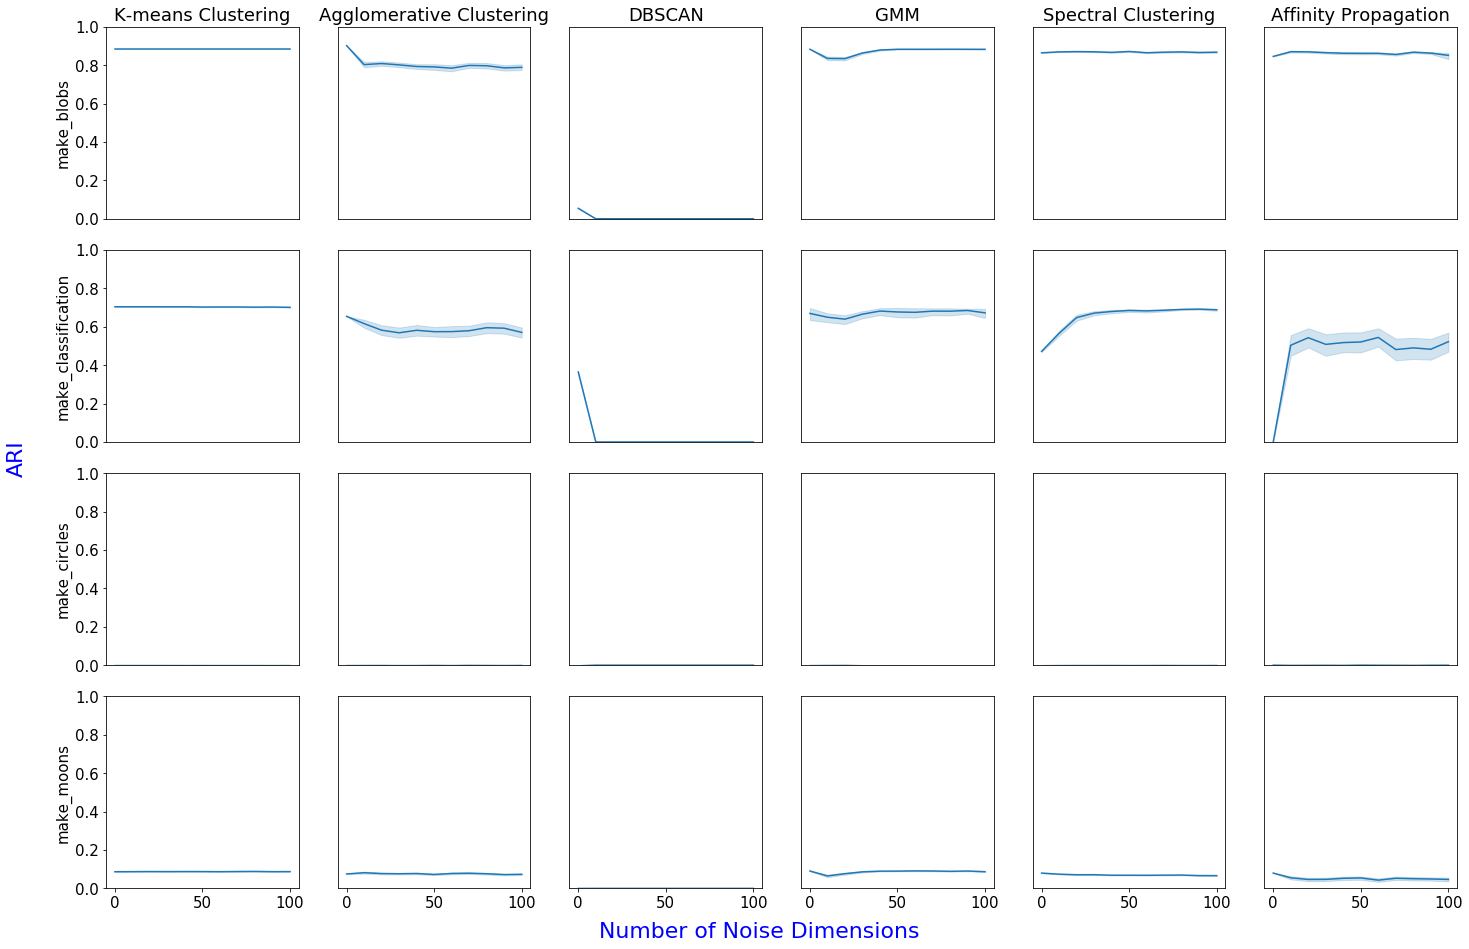

In [240]:
# plot when noise_std=0.1
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_1[index][ind],allTrialARI_1[index][ind],name,algoName)

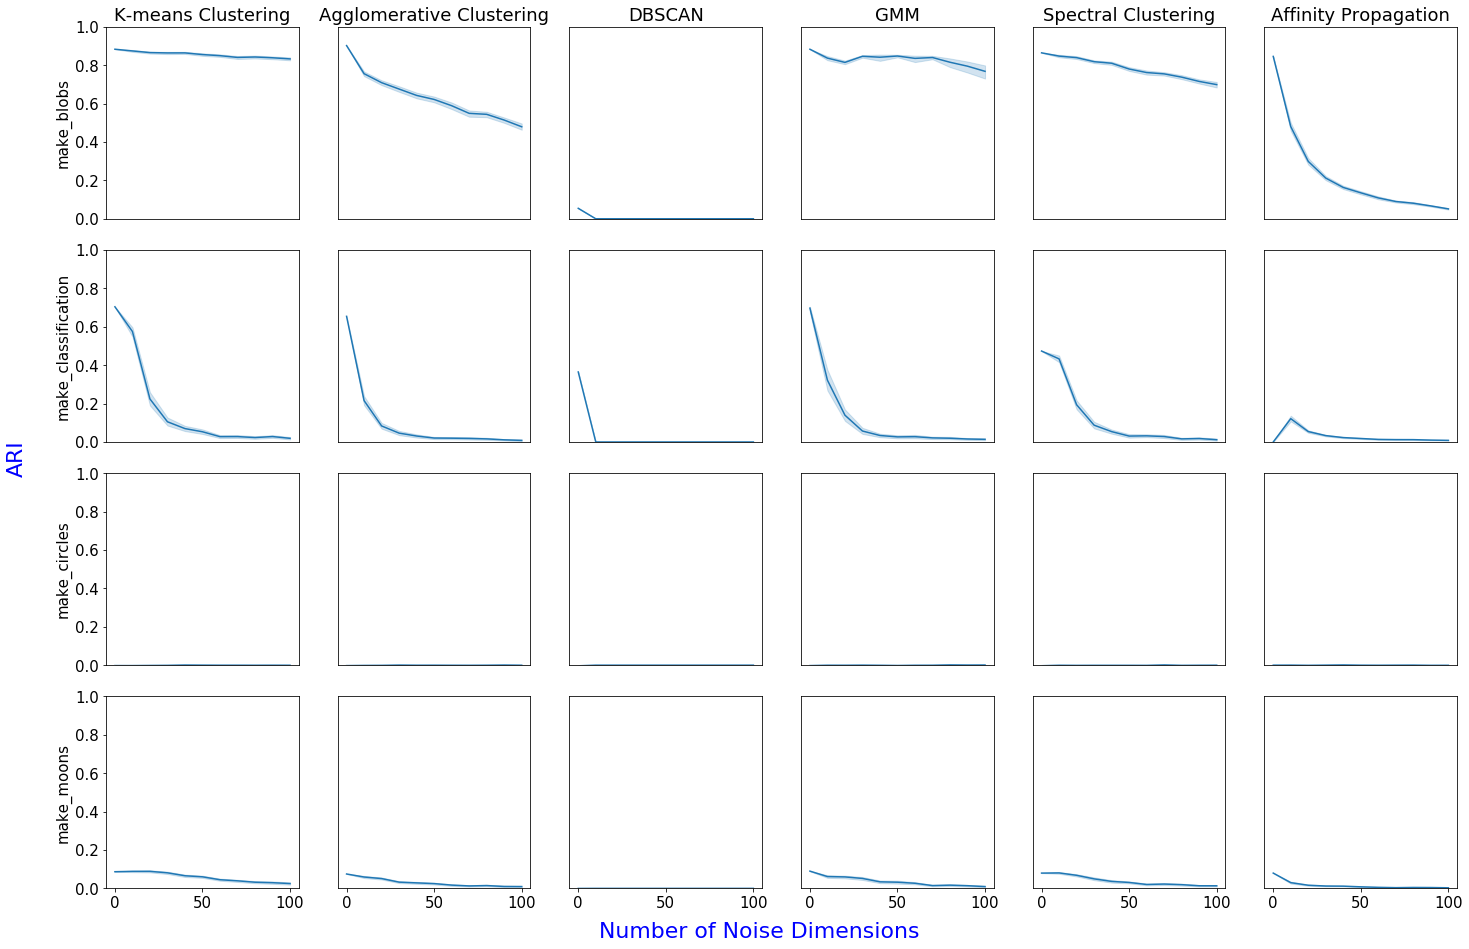

In [241]:
# plot when noise_std=1
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_2[index][ind],allTrialARI_2[index][ind],name,algoName)

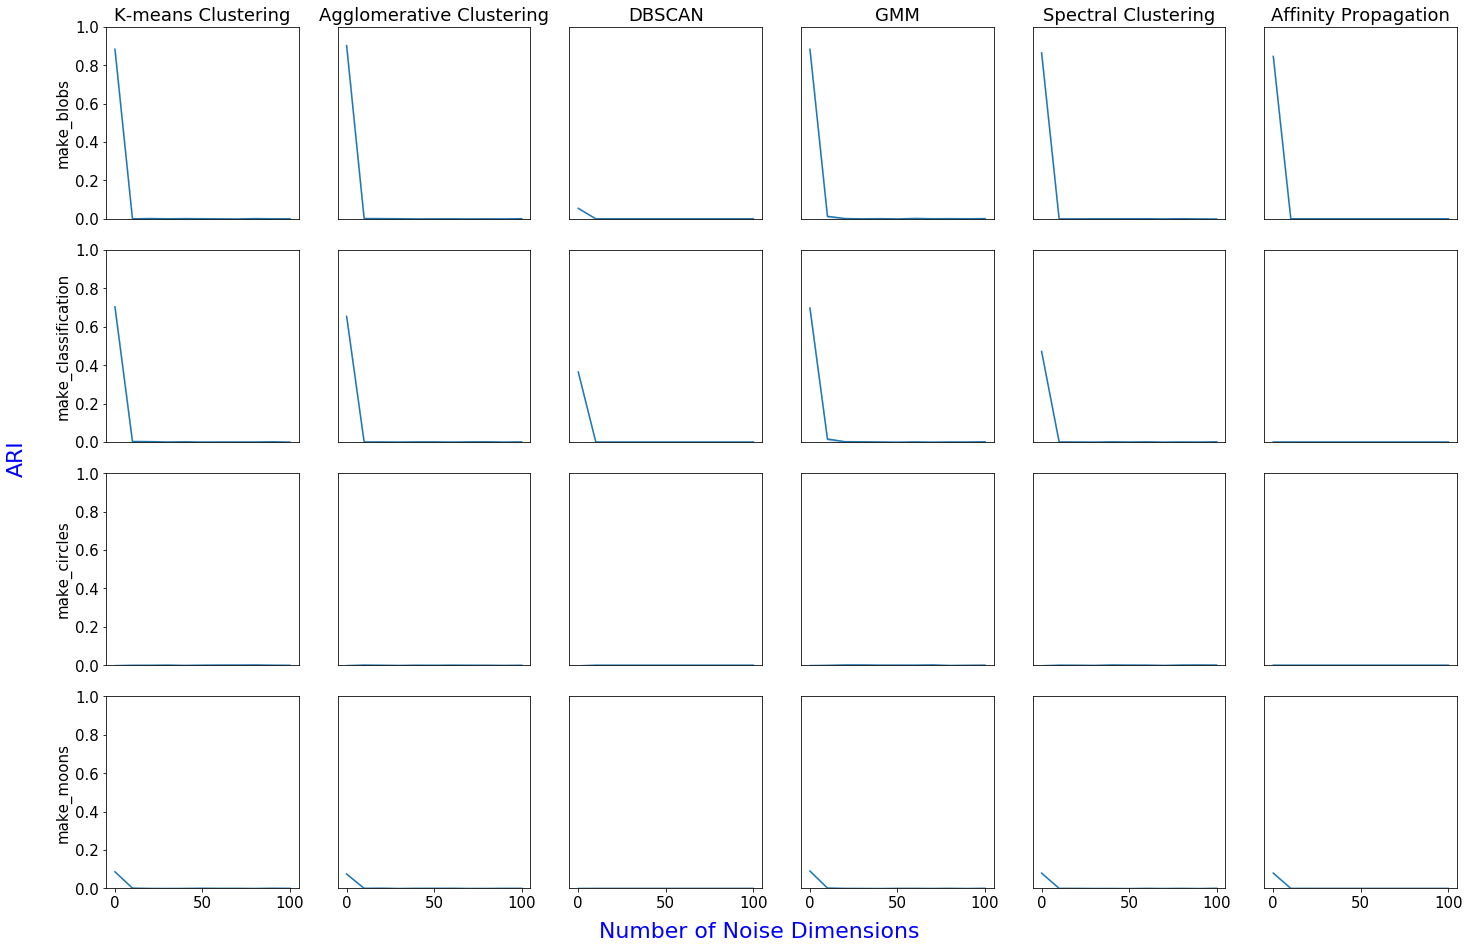

In [242]:
# plot when noise_std=10
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_3[index][ind],allTrialARI_3[index][ind],name,algoName)

## Comparing the results
The performance of different clustering algorithms on the same dataset can be compared if the ARI scores for different algorithms on a dataset are plotted together as follows. Here in most of the cases, GMM gives the best performance with the excepton in make_circles dataset. Also, GMM doesn't seem to be much affected by increasing noise dimensions compared to other clustering algorithms. Agglomerative cluster is another algorithm whose performance is comparable to that of GMM when the varaince of the noise added is very low. Moreover, as the subsequent figures show, agglomerative clustering is more susceptible to the variance of the noise added compared to GMM. On the other hand, when the variance of the noise added is higher, all the algorithms give bad performance irrespective of the number of noise dimensions.

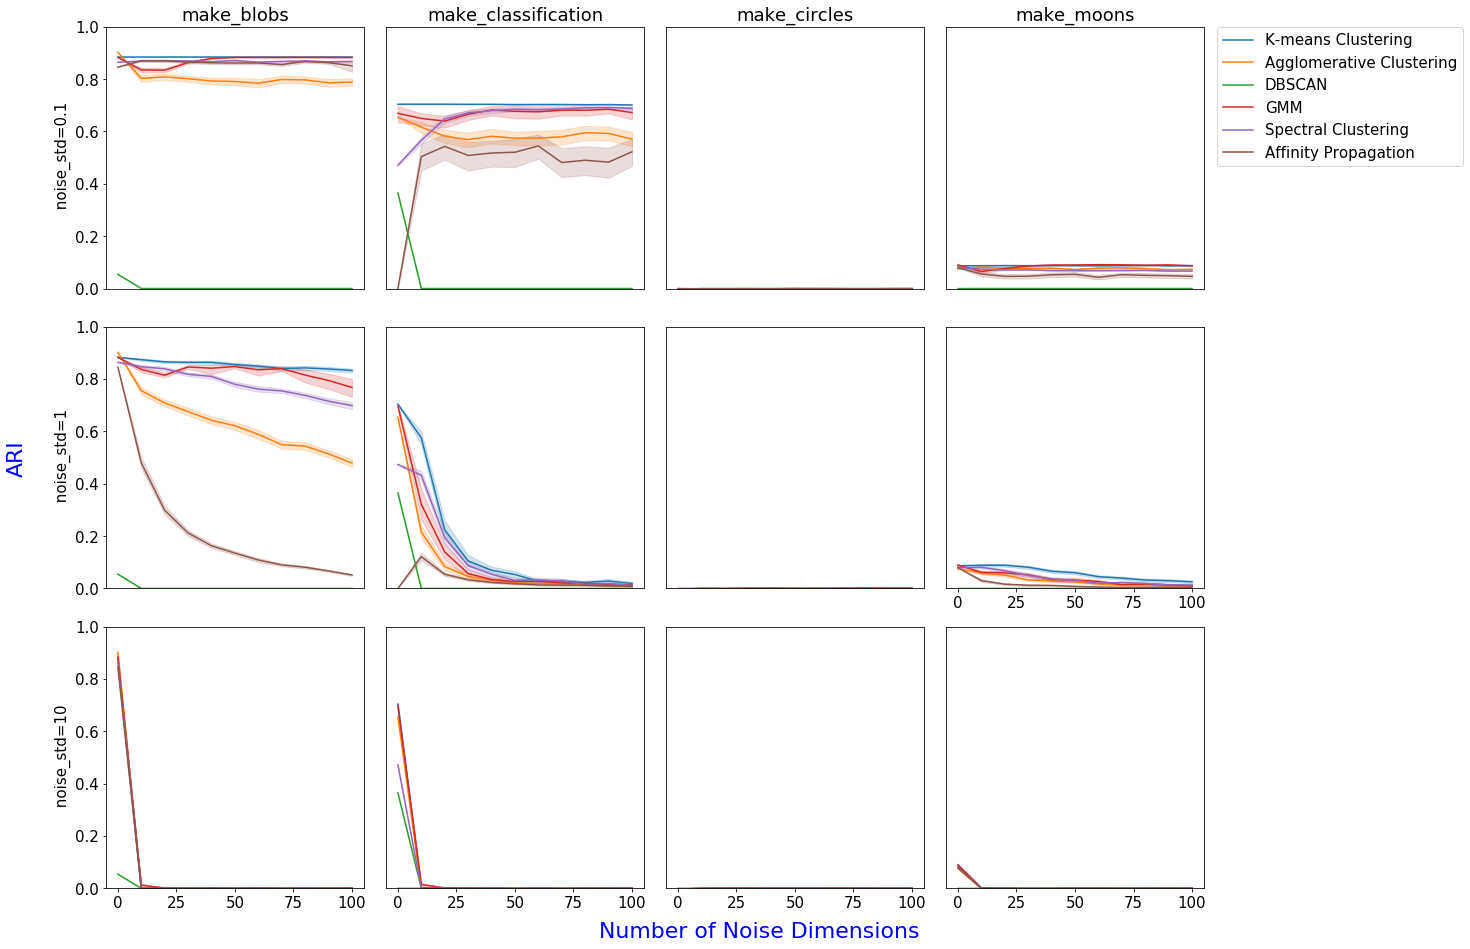

In [243]:
allARI=[allARI_1,allARI_2,allARI_3]
allNoise=[allNoise_1,allNoise_2,allNoise_3]
event=event_1 # event_1, event_2, and event_3 are all the same arrays
def plotAll(z,dimension,RandIndex,dataset,noise_level,event=event[0],x=len(noise_levels),y=len(datasets)):
    plt.subplot(x,y,z)
    data={'Number of Noise Dimensions':dimension,'ARI':RandIndex,'Event':event}
    ax=sns.lineplot(x='Number of Noise Dimensions',y='ARI',hue='Event',data=data)
    if (z%len(datasets)==1):
        plt.ylabel(' noise_std='+ str(noise_level))
    else:
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if(z<(len(noise_levels)-1)*len(datasets)):
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    if(z<=len(datasets)):
        plt.title(dataset)    
    plt.tight_layout()
    if(z!=len(datasets)):
        ax.legend_.remove()
    if(z==len(datasets)):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(0,1)
    return data

f,axes=plt.subplots(len(noise_levels),len(datasets),figsize=(20,13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,noise_level in enumerate(noise_levels):
    for ind,(dataset,name) in enumerate(zip(datasets,names)):
        plotAll(index*len(datasets)+1+ind,allNoise[index][ind],allARI[index][ind],name,noise_level)